**Байесовский классификатор: линейный дискриминант Фишера**

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# from sklearn.preprocessing import MinMaxScaler

# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc



---

In [2]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

##  загружаем данные 

In [3]:
data = [
    np.loadtxt('../data/200_2b/points_1.txt'),
    np.loadtxt('../data/200_2b/points_2.txt') 
]
lmbd = np.asarray([ 1.1, 1.1, ])  # коэффициент "цены" ошибки

In [4]:
# data = [
#     np.loadtxt('../data/399_4/points_b.txt'),
#     np.loadtxt('../data/399_4/points_g.txt'),
#     np.loadtxt('../data/399_4/points_r.txt'),
#     np.loadtxt('../data/399_4/points_y.txt'),
# ]

# lmbd = np.asarray([ 1.1, 1.1, 1.1, 1.11 ])  # коэффициент "цены" ошибки

In [5]:
# data = [
#     np.loadtxt('../data/6402_2/points_1.txt'),
#     np.loadtxt('../data/6402_2/points_2.txt')
# ]
# lmbd = np.asarray([ 1.1, 1.1, ]) # коэффициент "цены" ошибки


In [6]:
# data = [
#     np.loadtxt('../data/1998_2/points_b.txt'),
#     np.loadtxt('../data/1998_2/points_r.txt')    
# ]

# lmbd = np.asarray([ 1.1, 1.15, ]) # коэффициент "цены" ошибки



---

In [7]:
# собираем вместе
X = np.vstack(data)

n_cls = len(data) # количество классов

# метки классов
y = [ [i]*data[i].shape[0] for i in range(n_cls)]
y = [ item for sublist in y for item in sublist ]
y = np.asarray(y) 

X.shape, y.shape

((200, 2), (200,))

In [8]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=get_seed() )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100, 2), (100,), (100, 2), (100,))

In [9]:
%xdel X
%xdel y

---

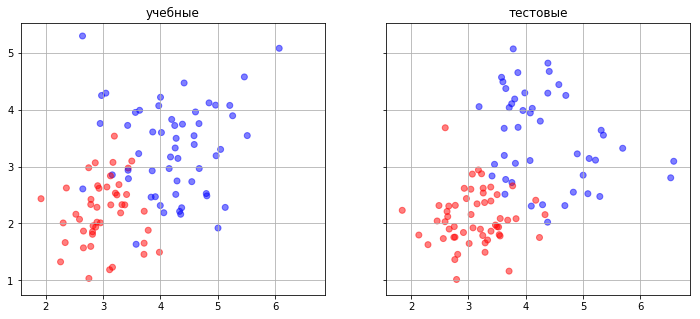

In [10]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_train  ]
axarr[0].set_title('учебные')
axarr[0].set
axarr[0].scatter( x=X_train[:,0], y=X_train[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in y_test  ]
axarr[1].set_title('тестовые')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()

##  классификатор

$ 
a(x) = \underset{y\in Y}{\operatorname{argmax}} 
\left[ \ln(\lambda_y P_y) - \frac{1}{2} \mu_y \Sigma^{-1} \mu_y^T + x \Sigma^{-1} \mu_y^T \right] 
$

In [11]:
# априорные вероятности классов
Py = np.asarray([ (y_train==c).sum() for c in sorted(set(y_train)) ])
Py = Py/Py.sum()
Py

array([0.55, 0.45])

In [12]:
# мат.ожидания классов
mu = np.vstack([ X_train[y_train==y,:].mean(axis=0) for y in set(y_train) ] )
mu

array([[4.22682889, 3.31606816],
       [3.00458838, 2.20024447]])

In [13]:
S = np.cov(X_train.T) # общая матрица матрица ковариаций классов
iS = np.linalg.inv(S) # обратная матрица ковариаций классов

In [14]:
def bayes_score(X,mu,iS,lmbd):
    return np.vstack([ 
       np.log(lmbd[i]*Py[i]) - 0.5* mu[i,:].dot(iS).dot(mu[i,:].T) + X.dot(iS).dot(mu[i,:].T) 
       for i in range(mu.shape[0])
    ])

In [15]:
def bayes(X,mu,iS,lmbd):
    return np.argmax( bayes_score(X,mu,iS,lmbd) ,axis=0)

##  результаты теста

In [16]:
o = bayes(X_test,mu,iS,lmbd)

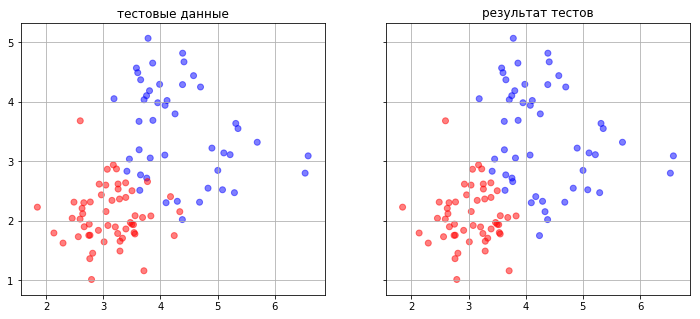

In [17]:
f, axarr = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
    
c = [ ['b','r','g','y'][j] for j in y_test  ]

axarr[0].set_title('тестовые данные')
axarr[0].set
axarr[0].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[0].grid()

c = [ ['b','r','g','y'][j] for j in o  ]
axarr[1].set_title('результат тестов')
axarr[1].scatter( x=X_test[:,0], y=X_test[:,1], c=c,  alpha=0.5 )
axarr[1].grid()

plt.show()


## метрики качества

In [18]:
print( classification_report(y_test,o) )

             precision    recall  f1-score   support

          0       0.92      1.00      0.96        45
          1       1.00      0.93      0.96        55

avg / total       0.96      0.96      0.96       100



In [19]:
cm = confusion_matrix(y_test,o)

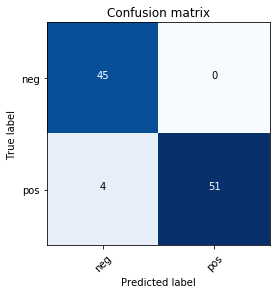

In [20]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# plt.colorbar()

classes = ['neg','pos'] if n_cls<3 else list(range(n_cls))

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()